In [1]:
# Import Packages
import numpy as np
import pandas as pd


# Import as Dataframe
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
df['date'] = pd.to_datetime(df['date'])
# Set the date as index 
df = df.set_index('date')
# Select the proper time period for weekly aggreagation
df = df['1991-07-01':'2008-12-29'].resample('W').sum()
df.head()


,value
date,
1991-07-07,3.526591
1991-07-14,0.000000
1991-07-21,0.000000
1991-07-28,0.000000
1991-08-04,3.180891


C:\Users\mca52\AppData\Local\Temp\ipykernel_26108\4108747144.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')


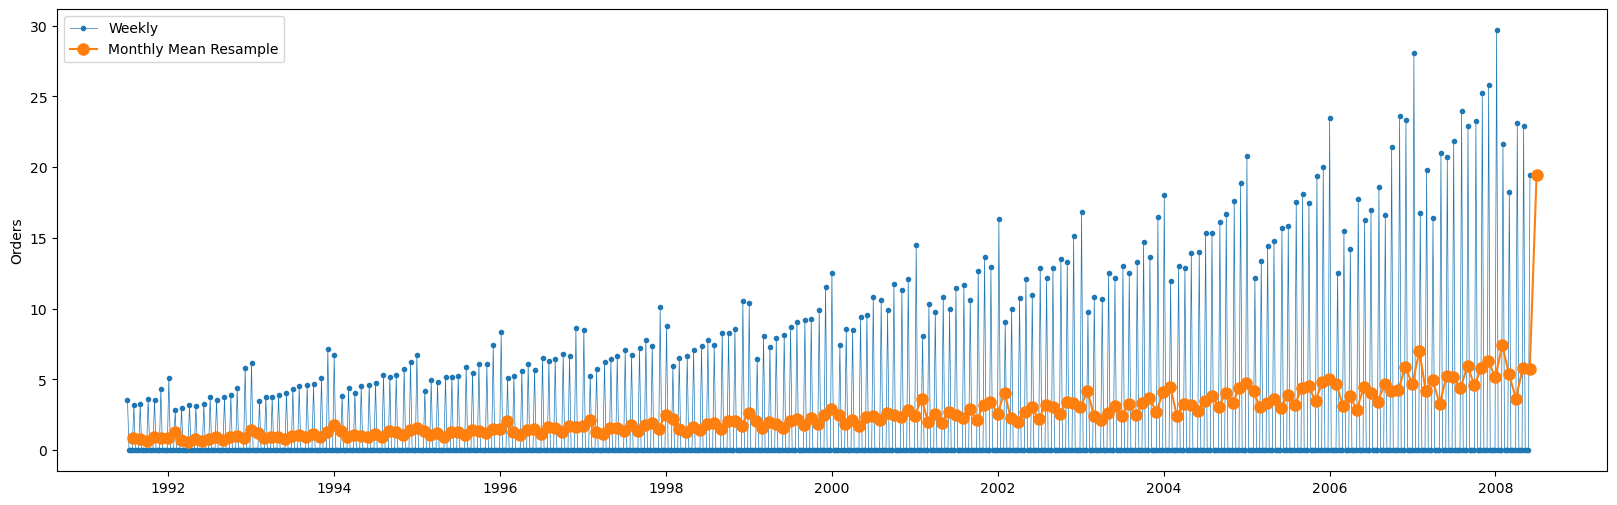

In [2]:
# checks: (a) Level : Average value in the Series (b) Trend: Fitted Line (c) Seasonal Patterns: periodic fluctuations

import warnings
import matplotlib.pyplot as plt
y = df['value']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Orders')
ax.legend();

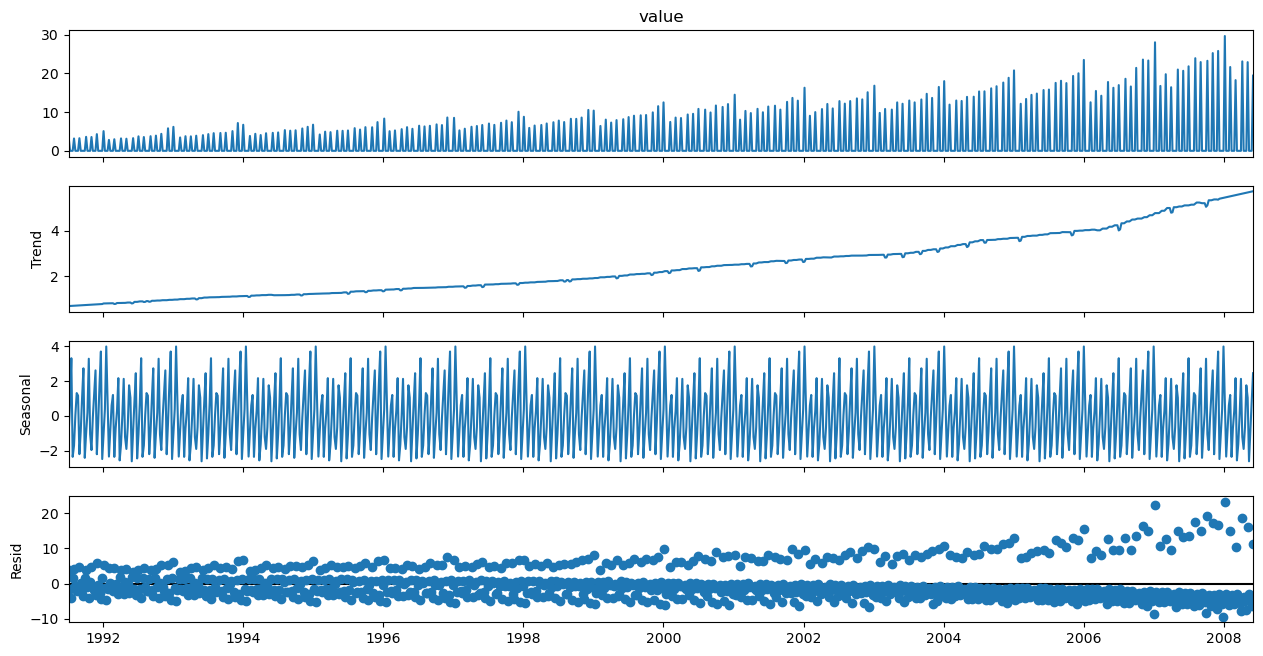

In [3]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()
seasonal_decompose(y)

In [4]:
#Seasonality
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

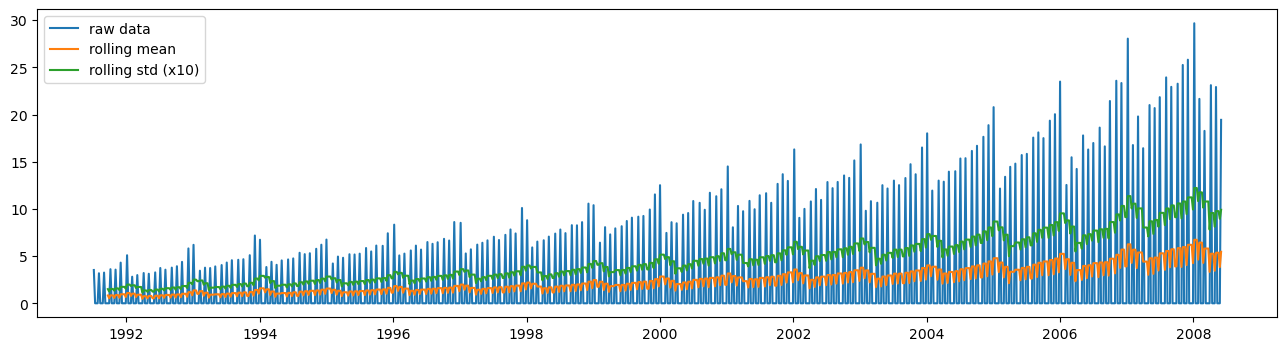

In [5]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')


In [6]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [7]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -0.660
P-value = 0.857
Critical values :
	1%: -3.4379677736185514 - The data is not stationary with 99% confidence
	5%: -2.8649026847264074 - The data is not stationary with 95% confidence
	10%: -2.568560548763626 - The data is not stationary with 90% confidence


 > Is the de-trended data stationary ?
Test statistic = -11.104
P-value = 0.000
Critical values :
	1%: -3.438057561354894 - The data is  stationary with 99% confidence
	5%: -2.864942268638857 - The data is  stationary with 95% confidence
	10%: -2.5685816343390853 - The data is  stationary with 90% confidence


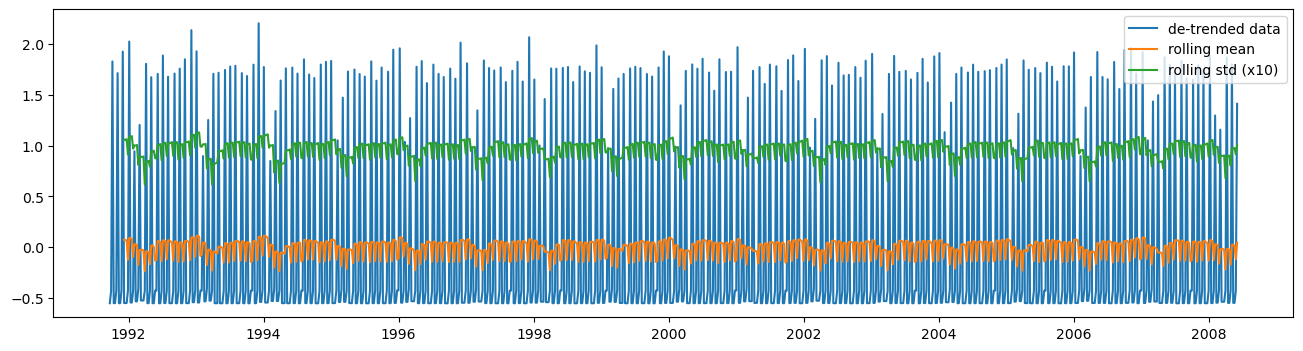

In [8]:
# Detrending
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

 > Is the 12 lag differenced data stationary ?
Test statistic = -6.762
P-value = 0.000
Critical values :
	1%: -3.4380757734945697 - The data is  stationary with 99% confidence
	5%: -2.8649502975181314 - The data is  stationary with 95% confidence
	10%: -2.5685859111876925 - The data is  stationary with 90% confidence


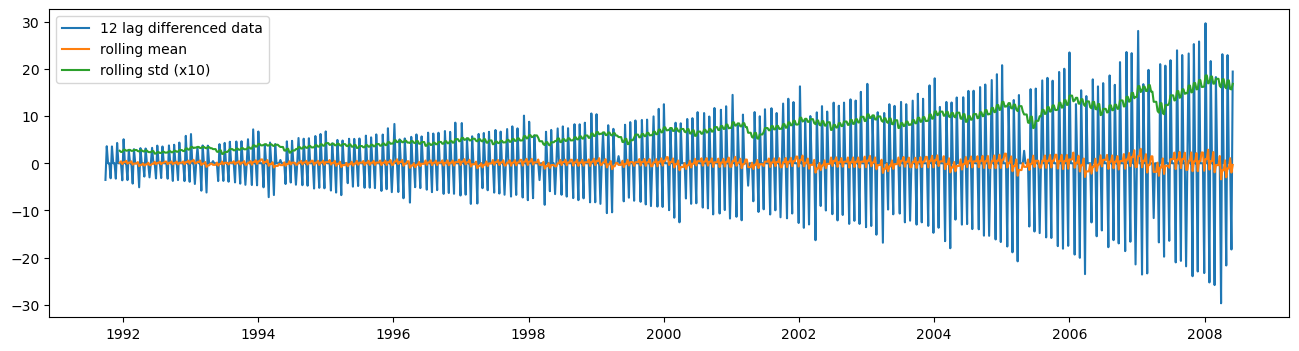

In [9]:
# Differencing
y_12lag =  y - y.shift(12)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -8.280
P-value = 0.000
Critical values :
	1%: -3.4381774989729816 - The data is  stationary with 99% confidence
	5%: -2.8649951426291 - The data is  stationary with 95% confidence
	10%: -2.568609799556849 - The data is  stationary with 90% confidence


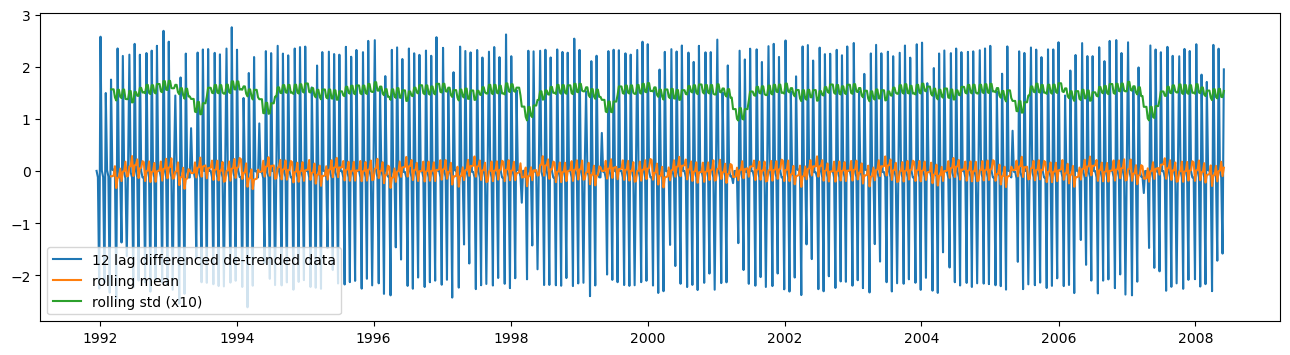

In [10]:
# Detrending + Differencing

y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')


In [11]:
#Set the y_to_train, y_to_test, and the length of predict units

y_to_train = y[:'2006-05-26'] # dataset to train
y_to_val = y['2006-06-02':] # last X months for test  
predict_date = len(y) - len(y[:'2007-06-02']) # the number of data points for the test set


In [12]:
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing 

def ses(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    # specific smoothing level
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()

The Root Mean Squared Error of our forecasts with smoothing level of 0.8 is 9.46
The Root Mean Squared Error of our forecasts with auto optimization is 8.61


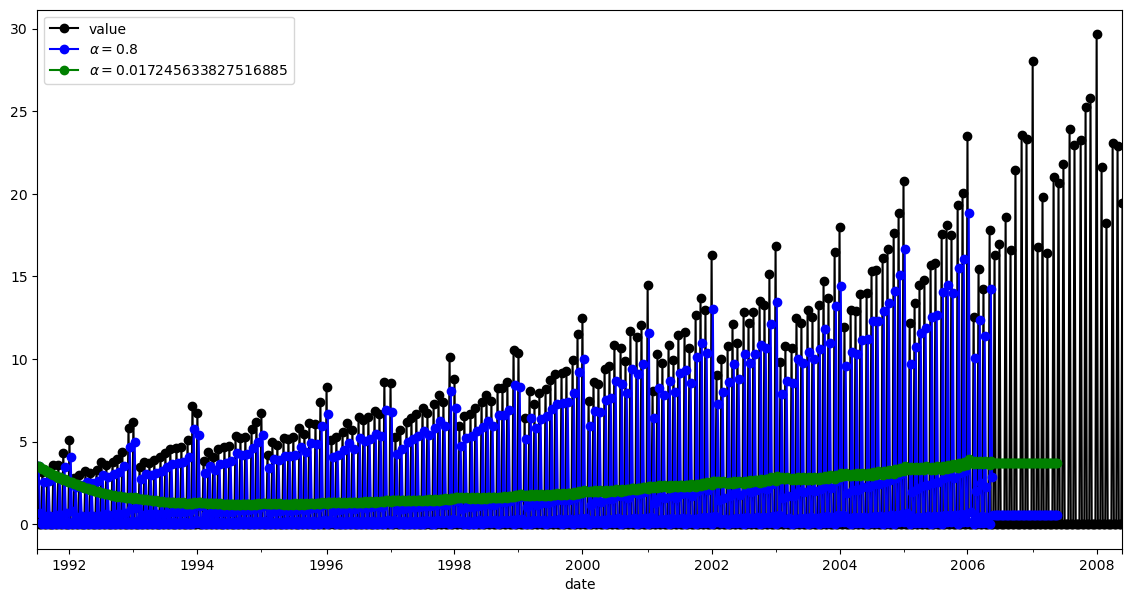

In [13]:
ses(y, y_to_train,y_to_val,0.8,predict_date)

The Root Mean Squared Error of our forecasts with smoothing level of 0.8 is 9.46
The Root Mean Squared Error of our forecasts with auto optimization is 8.61


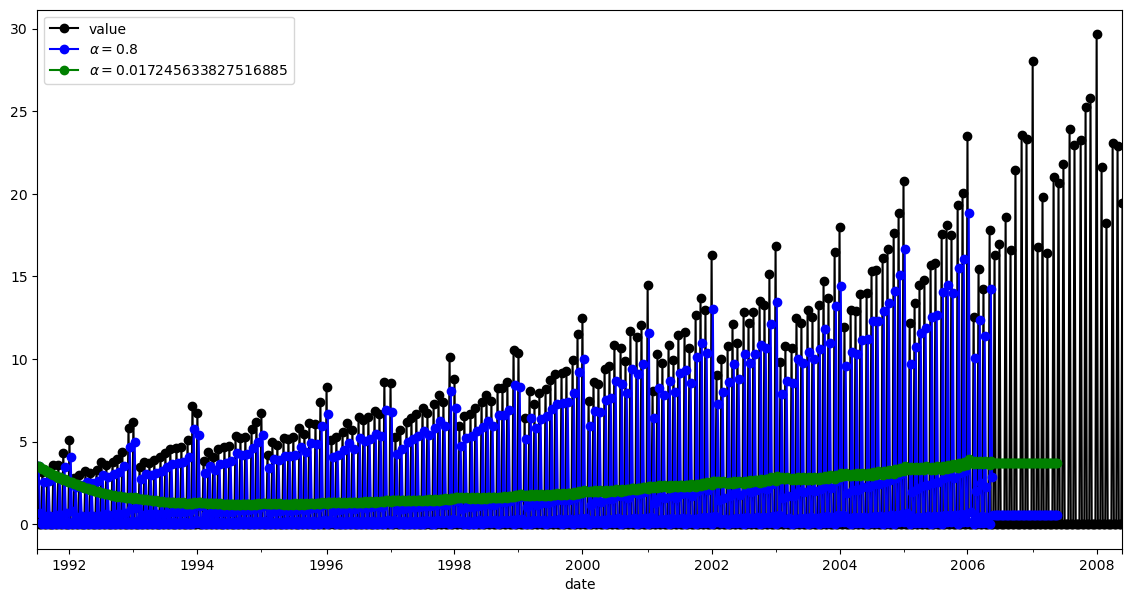

In [14]:
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing 

def ses(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    # specific smoothing level
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()
    
ses(y, y_to_train,y_to_val,0.8,predict_date)

The Root Mean Squared Error of Holts Linear trend 17.63
The Root Mean Squared Error of Holts Exponential trend 17.63


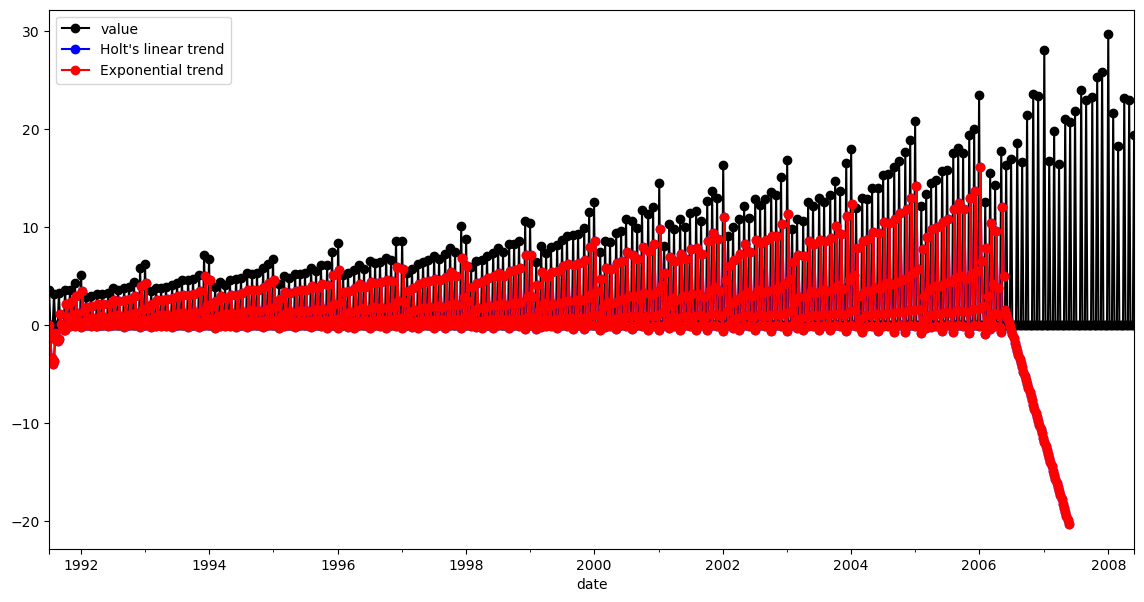

In [16]:
from statsmodels.tsa.api import Holt

def holt(y,y_to_train,y_to_test,smoothing_level,smoothing_slope, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's linear trend")
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))

    fit2 = Holt(y_to_train, exponential=False).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast2 = fit2.forecast(predict_date).rename("Exponential trend")
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    
    fit1.fittedvalues.plot(marker="o", color='blue')
    fcast1.plot(color='blue', marker="o", legend=True)
    fit2.fittedvalues.plot(marker="o", color='red')
    fcast2.plot(color='red', marker="o", legend=True)

    plt.show()
holt(y, y_to_train,y_to_val,0.6,0.2,predict_date)

Box-Cox disabled: data contains zero or negative values.
RMSE (additive trend, additive seasonal, Box-Cox=False): 5.24
RMSE (additive damped trend, additive seasonal, Box-Cox=False): 5.26


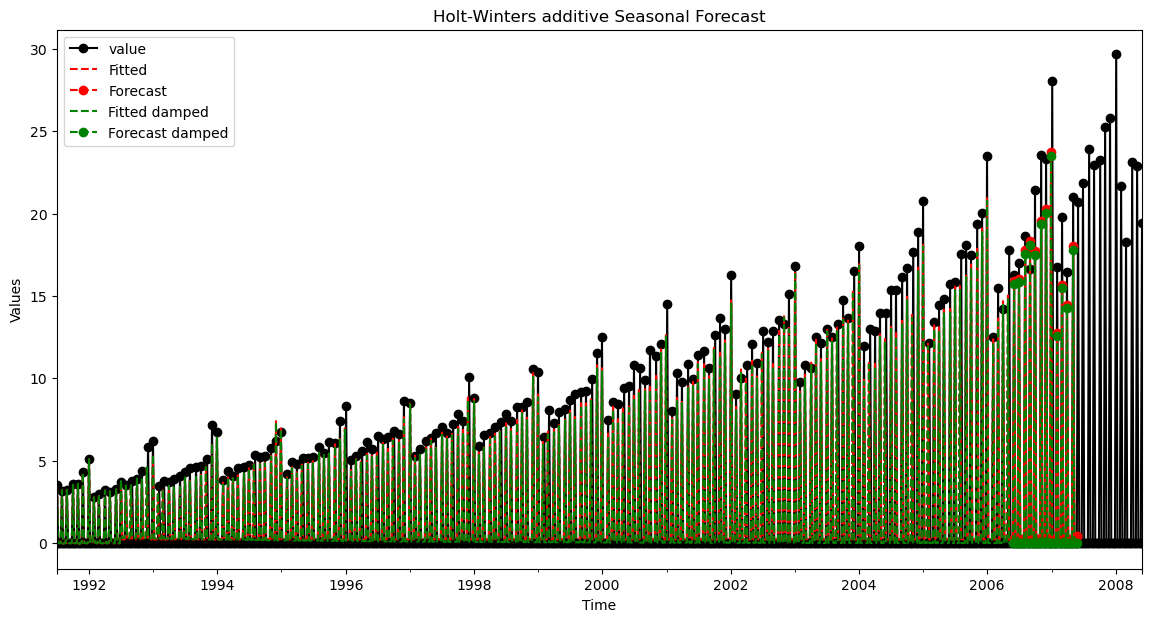

In [19]:
from statsmodels.tsa.api import ExponentialSmoothing
import matplotlib.pyplot as plt
import numpy as np

def holt_win_sea(y, y_to_train, y_to_test, seasonal_type, seasonal_period, predict_date):
    """
    Holt-Winters exponential smoothing with additive or multiplicative seasonal components.
    
    Parameters:
    y              : full time series (for plotting)
    y_to_train     : training data series
    y_to_test      : test data series
    seasonal_type  : 'additive' or 'multiplicative'
    seasonal_period: length of seasonal period (int)
    predict_date   : number of periods to forecast
    """
    
    # Plot original series
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    # Validate seasonal type
    if seasonal_type not in ['additive', 'multiplicative']:
        print('Wrong Seasonal Type. Please choose "additive" or "multiplicative".')
        return
    
    seasonal_arg = 'add' if seasonal_type == 'additive' else 'mul'
    
    # Automatically disable Box-Cox if data has zeros or negatives
    use_boxcox = True
    if (y_to_train <= 0).any():
        use_boxcox = False
        print("Box-Cox disabled: data contains zero or negative values.")
    
    # Standard model
    fit = ExponentialSmoothing(
        y_to_train,
        seasonal_periods=seasonal_period,
        trend='add',
        seasonal=seasonal_arg,
        damped_trend=False,
        use_boxcox=use_boxcox
    ).fit()
    
    fcast = fit.forecast(predict_date)
    mse = ((fcast - y_to_test) ** 2).mean()
    print(f'RMSE ({seasonal_type} trend, {seasonal_type} seasonal, Box-Cox={use_boxcox}): {np.sqrt(mse):.2f}')
    
    # Damped trend model
    fit_damped = ExponentialSmoothing(
        y_to_train,
        seasonal_periods=seasonal_period,
        trend='add',
        seasonal=seasonal_arg,
        damped_trend=True,
        use_boxcox=use_boxcox
    ).fit()
    
    fcast_damped = fit_damped.forecast(predict_date)
    mse_damped = ((fcast_damped - y_to_test) ** 2).mean()
    print(f'RMSE ({seasonal_type} damped trend, {seasonal_type} seasonal, Box-Cox={use_boxcox}): {np.sqrt(mse_damped):.2f}')
    
    # Plot fitted and forecast values
    fit.fittedvalues.plot(style='--', color='red', label='Fitted')
    fcast.plot(style='--', marker='o', color='red', legend=True, label='Forecast')
    
    fit_damped.fittedvalues.plot(style='--', color='green', label='Fitted damped')
    fcast_damped.plot(style='--', marker='o', color='green', legend=True, label='Forecast damped')
    
    plt.title(f"Holt-Winters {seasonal_type} Seasonal Forecast")
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.legend()
    plt.show()

# Example usage
holt_win_sea(y, y_to_train, y_to_val, 'additive', 52, predict_date)


In [ ]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))
sarima_grid_search(y,52)

In [ ]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)
model = sarima_eva(y,(1, 1, 1),(1, 1, 0, 52),52,'2008-06-02',y_to_val)

In [ ]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)
final_table = forecast(model,52,y)
final_table.head()

In [ ]:
### Graphs show only the perdiected period
final_table.index = final_table.Date
fig, ax = plt.subplots( figsize=(14, 7))
# ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(final_table.Predicted_Mean,marker='.', linestyle='-', linewidth=0.5, label='Predicted Weekly')
# ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(final_table.Predicted_Mean.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Predicted Monthly Mean Resample')
ax.set_ylabel('Orders')
ax.legend();